# Requirements

In [1]:
import time
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import randint

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax import random
from jax.scipy.special import logsumexp

import mnist

# Neural network

In [7]:
x_train, t_train, x_test, t_test = mnist.load()
x_train, t_train, x_test, t_test = x_train[:2000], t_train[:2000], x_test[:2000], t_test[:2000]
num_pixels = x_train.shape[1]
num_labels = np.unique(t_train).shape[0]
print(f"Training data samples: {x_train.shape[0]}")

Training data samples: 2000


In [8]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale=1e-2):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def random_tangent(m, n, scale):
    return scale*np.random.rand(n, m), scale*np.random.rand(n)

def init_tangents(sizes, scale=1.0):
    return [random_tangent(m, n, scale) for m, n in zip(sizes[:-1], sizes[1:])]

def zero_vects(m, n):
    return np.zeros((n, m)), np.zeros((n))

def init_zeros(sizes):
    return [zero_vects(m, n) for m, n in zip(sizes[:-1], sizes[1:])]

class Batcher():
    def __init__(self, data, labels, batch_size) -> None:
        self.data = data
        self.labels = labels
        self.batch_size = batch_size

        self.counter = 0
    def reset(self):
        self.counter = 0

    def get_all(self):
        return self.data, self.labels

    def get_batch(self, randomomized=False):
        if randomomized and self.counter == 0:
            p = np.random.permutation(self.labels.shape[0])
            self.data = self.data[p]
            self.labels = self.labels[p]

        if self.batch_size * self.counter >= self.data.shape[0]:
            self.counter = 0
            return None, None
        
        elif self.batch_size * (self.counter+1) < self.data.shape[0]:
            data, labels = (
                self.data[self.counter*self.batch_size:(self.counter+1)*self.batch_size],
                self.labels[self.counter*self.batch_size:(self.counter+1)*self.batch_size],
            )
            self.counter += 1
            return data, labels
        else:
            data, labels = (
                self.data[self.counter*self.batch_size:],
                self.labels[self.counter*self.batch_size:],
            )
            self.counter += 1
            return data, labels

In [22]:
def relu(x):
    return jnp.maximum(0, x)

def predict(params, image):
    # per-example predictions
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
    
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

batched_predict = vmap(predict, in_axes=(None, 0))


def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
    # target_class = jnp.argmax(targets, axis=1)
    target_class = targets
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
    targets = one_hot(targets, num_labels)
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

def report(params, images, targets):
    preds = batched_predict(params, images)
    predicted_class = jnp.argmax(preds, axis=1)
    oh_targets = one_hot(targets, num_labels)

    return jnp.mean(predicted_class == targets), -jnp.mean(preds * oh_targets)

@jit
def fwd_ad_iteration(x, y, params, tangents):
    isolated_loss = lambda params: loss(params, x, y)

    t_0 = time.perf_counter()
    f_val, jvp = jax.jvp(isolated_loss, (params,), (tangents,))
    time_elapsed = time.perf_counter() - t_0

    return f_val, [(jvp*dw, jvp*db) for (dw, db) in tangents], time_elapsed

@jit
def rev_ad_iteration(x, y, params, tangents=None):
    isolated_loss = lambda params: loss(params, x, y)

    t_0 = time.perf_counter()
    f_val, vjp = jax.vjp(isolated_loss, *(params,))
    time_elapsed = time.perf_counter() - t_0

    return f_val, vjp((1.0))[0], time_elapsed

@jit
def update_params(params, grads, lr):
    return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]

@jit
def adam_update(grad, v, s, iteration, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

    new_v = [(beta1*dwv + (1 - beta1) * dw, beta1*dbv + (1 - beta1) * db) for (dwv, dbv), (dw, db) in zip(v, grad)]
    v_corrected = [(nvw /(1 - beta1 ** iteration), nvb /(1 - beta1 ** iteration)) for (nvw, nvb) in new_v]

    new_s = [(beta2*dws + (1 - beta2) * jnp.square(dw), beta2*dbs + (1 - beta2) * jnp.square(db)) for (dws, dbs), (dw, db) in zip(s, grad)]
    s_corrected = [(nsw /(1 - beta2 ** iteration), nsb /(1 - beta2 ** iteration)) for (nsw, nsb) in new_s]

    adapted_grad = [(vcw /(jnp.sqrt(scw) + epsilon), vcb /(jnp.sqrt(scb) + epsilon)) for (vcw, vcb), (scw, scb) in zip(v_corrected, s_corrected)]
    
    return adapted_grad, new_v, new_s

## No optimizer

In [23]:
ad_dict = {
    "Forward": fwd_ad_iteration,
    "Reverse": rev_ad_iteration,
}
optimization = [
    "No optimization", 
    "Adam",
]

In [38]:
layer_sizes = [784, 10]
num_epochs = 50
# num_epochs = 2
batch_size = 100

logs = []
epoch_logs = []
for exp in range(1):
    log = {
        "Iteration": [],
        "Time": [],
        "Test accuracy": [],
        "Test loss": [],
        "Train accuracy": [],
        "Train loss": [],
        "AD mode": [],
        "Optimization": [],
    }
    epoch_log = {
        "Epoch": [],
        "Time": [],
        "Test accuracy": [],
        "Test loss": [],
        "Train accuracy": [],
        "Train loss": [],
        "AD mode": [],
        "Optimization": [],
    }

    for opt in optimization:
        for ad_name, ad_func in ad_dict.items():
            lr = 1e-3
            params = init_network_params(layer_sizes, random.PRNGKey(0))
            v = init_zeros(layer_sizes)
            s = init_zeros(layer_sizes)

            time_elapsed = 0.0
            update_iter = 0

            batcher = Batcher(x_train, t_train, batch_size)

            train_acc, train_loss = report(params, x_train, t_train)
            test_acc, test_loss = report(params, x_test, t_test)

            log["Iteration"].append(0)
            log["Time"].append(0)
            log["Test accuracy"].append(test_acc)
            log["Test loss"].append(test_loss)
            log["Train accuracy"].append(train_acc)
            log["Train loss"].append(train_loss)
            log["AD mode"].append(ad_name)
            log["Optimization"].append(opt)

            epoch_log["Epoch"].append(0)
            epoch_log["Time"].append(0)
            epoch_log["Test accuracy"].append(test_acc)
            epoch_log["Test loss"].append(test_loss)
            epoch_log["Train accuracy"].append(train_acc)
            epoch_log["Train loss"].append(train_loss)
            epoch_log["AD mode"].append(ad_name)
            epoch_log["Optimization"].append(opt)

            for epoch in range(num_epochs):
                start_time = time.time()
                x, y = batcher.get_batch(randomomized=True)
                
                while x is not None and y is not None:
                    print(f"Iteration {update_iter}")
                    tangents = init_tangents(layer_sizes)

                    x = jnp.reshape(x, (len(x), num_pixels))

                    loss_v, grad, delta_t = ad_func(x, y, params, tangents)

                    if opt == "Adam":
                        grad, v, s = adam_update(grad, v, s, update_iter+1)
                    params = update_params(params, grad, lr)

                    if opt != "Adam":
                        lr *= 0.9999
                    
                    time_elapsed += delta_t

                    train_acc, train_loss = report(params, x_train, t_train)
                    test_acc, test_loss = report(params, x_test, t_test)

                    log["Iteration"].append(update_iter+1)
                    log["Time"].append(time_elapsed)
                    log["Test accuracy"].append(test_acc)
                    log["Test loss"].append(test_loss)
                    log["Train accuracy"].append(train_acc)
                    log["Train loss"].append(train_loss)
                    log["AD mode"].append(ad_name)
                    log["Optimization"].append(opt)

                    x, y = batcher.get_batch(randomomized=True)

                    update_iter += 1


                print(f"Epoch {epoch}")

                epoch_log["Epoch"].append(epoch+1)
                epoch_log["Time"].append(time_elapsed)
                epoch_log["Test accuracy"].append(test_acc)
                epoch_log["Test loss"].append(test_loss)
                epoch_log["Train accuracy"].append(train_acc)
                epoch_log["Train loss"].append(train_loss)
                epoch_log["AD mode"].append(ad_name)
                epoch_log["Optimization"].append(opt)
    
    logs.append(pd.DataFrame(log))
    epoch_logs.append(pd.DataFrame(epoch_log))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Epoch 0
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Epoch 1
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Epoch 2
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 7

In [33]:
for i, log in enumerate(logs):
    log.to_csv(f"./nn_results/log_{i}.csv")
for i, log in enumerate(epoch_logs):
    log.to_csv(f"./nn_results/exp_log_{i}.csv")

# Visualize

In [36]:
df

,Iteration,Time,Test accuracy,Test loss,Train accuracy,Train loss,AD mode,Optimization
0,0,0,0.09,3.6205132,0.08450001,3.5563457,Forward,No optimization
1,1,0.015697269,0.0895,26.943014,0.079500005,27.110355,Forward,No optimization
2,2,0.031394538,0.080000006,28.272577,0.082,29.520231,Forward,No optimization
3,3,0.047091804,0.104,48.26113,0.109500006,49.580322,Forward,No optimization
4,4,0.062789075,0.11750001,50.806553,0.09,53.488197,Forward,No optimization
...,...,...,...,...,...,...,...,...
159,36,0.76683515,0.82150006,2.4102335,0.906,1.0582999,Reverse,Adam
160,37,0.7881361,0.81650007,2.5119145,0.90900004,1.0371468,Reverse,Adam
161,38,0.8094371,0.8105,2.6555917,0.90650004,1.070974,Reverse,Adam
162,39,0.83073807,0.80550003,2.7842116,0.90050006,1.131203,Reverse,Adam


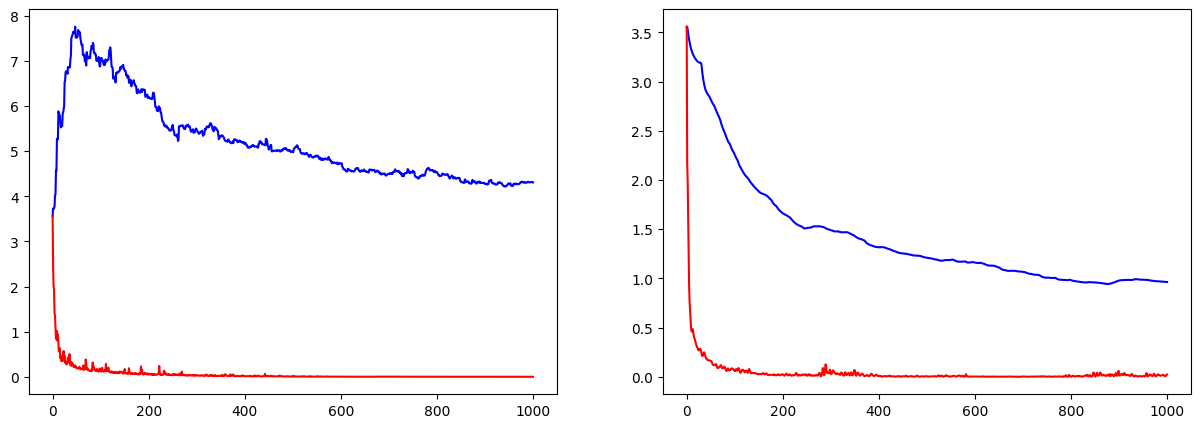

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

df = logs[0]

no_data = df[df["Optimization"] == "No optimization"]
ax[0].plot(no_data[no_data['AD mode'] == "Forward"]['Iteration'],no_data[no_data['AD mode'] == "Forward"]['Train loss'],
                color='blue')
ax[0].plot(no_data[no_data['AD mode'] == "Reverse"]['Iteration'],no_data[no_data['AD mode'] == "Reverse"]['Train loss'],
                color='red')

adam_data = df[df["Optimization"] == "Adam"]
ax[1].plot(adam_data[adam_data['AD mode'] == "Forward"]['Iteration'],adam_data[adam_data['AD mode'] == "Forward"]['Train loss'],
                color='blue')
ax[1].plot(adam_data[adam_data['AD mode'] == "Reverse"]['Iteration'],adam_data[adam_data['AD mode'] == "Reverse"]['Train loss'],
                color='red')

plt.show()

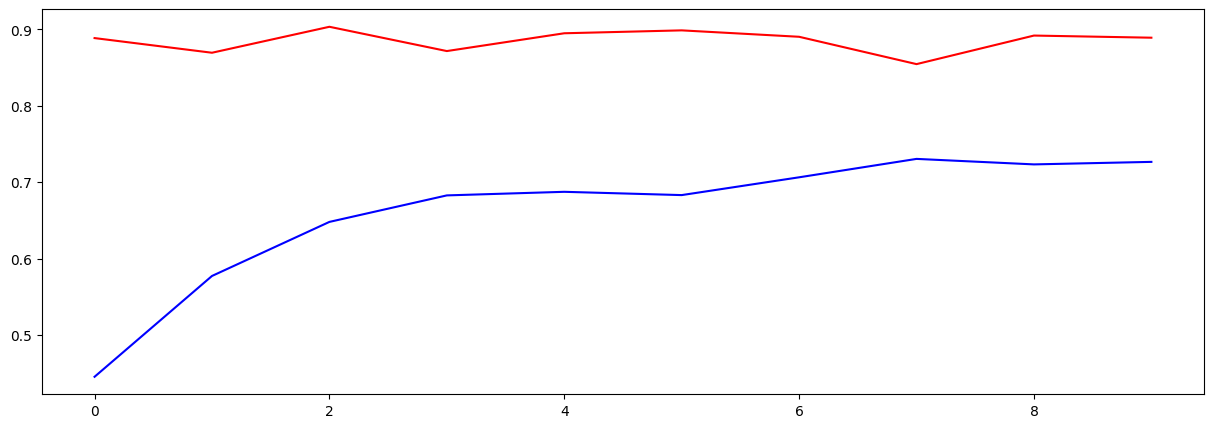

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(test_df[test_df['AD mode'] == "Forward"]['epoch'],test_df[test_df['AD mode'] == "Forward"]['accuracy'],
                color='blue')
ax.plot(test_df[test_df['AD mode'] == "Reverse"]['epoch'],test_df[test_df['AD mode'] == "Reverse"]['accuracy'],
                color='red')

plt.show()